# Forecasting Malaysia's Total Export Value with Machine Learning Regression Models

In [65]:
# Library or Package required
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.utils import shuffle
from lazypredict.Supervised import LazyRegressor

def explain(a):
    print(a.__doc__)

# Data Preparation
## Data Extraction and Data Integration

In [2]:
# To extract Malaysia export data from year 2000 to year 2022
exp00_04 = pd.read_excel("./Dataset/2000-2004.xlsx", header=5)
exp05_09 = pd.read_excel("./Dataset/2005-2009.xlsx", header=5)
exp10_14 = pd.read_excel("./Dataset/2010-2014.xlsx", header=5)
exp15_19 = pd.read_excel("./Dataset/2015-2019.xlsx", header=5)
exp20_22 = pd.read_excel("./Dataset/2020-2022.xlsx", header=5)

export = [exp00_04, exp05_09, exp10_14, exp15_19, exp20_22]
year_list = []
export_list = []

# To integrate the extracted dataset into one unified dataset
for item in export:
    # To transpose the column and rows
    melted_item = pd.melt(item.tail(1), var_name = 'year', value_name = 'export')
    
    # To convert data into numeric and remove non-numeric data
    melted_item = melted_item.apply(pd.to_numeric, errors = 'coerce')
    melted_item = melted_item.dropna()
    
    # To convert the year data into date format
    melted_item['year'] = pd.to_datetime(melted_item['year'], format= '%Y').dt.year
    
    # To reset the dataframe index
    clean_data1 = melted_item.reset_index(drop = True)
    
    # To convert the column data into list
    year_list.extend(clean_data1['year'].to_list())
    export_list.extend(clean_data1['export'].to_list())
    
# Create a dictionary from the lists
data1 = {'year' : year_list,
        'export' : export_list}

# Create a dataframe from the unified dataset
# To create dataframe based on the merged dataset
df1 = pd.DataFrame(data1)
display(df1.head())

,year,export
0,2000,373270315498.00
1,2001,334283814638.00
2,2002,357430016975.00
3,2003,397884391228.00
4,2004,481252992429.00


In [3]:
# Extract other datasets (exchange rate, real effective exchange rate, population, gdp)
ex = pd.read_csv("./Dataset/Currency.csv", header=2)
reer = pd.read_excel("./Dataset/Real Effective Exchange Rate.xlsx", header=3)
pop = pd.read_csv("./Dataset/Population.csv", header=2)
gdp = pd.read_csv("./Dataset/GDP.csv", header=2)

# To filter out Malaysia's data
ex = ex[ex['Country Name'] == 'Malaysia']
# To transpose the column and rows
melted_ex = pd.melt(ex, var_name = 'year',  value_name = 'ER')

# To filter out Malaysia's data
reer = reer[reer['Country Name'] == 'Malaysia']
# To transpose the column and rows
melted_reer = pd.melt(reer, var_name = 'year', value_name = 'REER')

# To filter out Malaysia's data
pop = pop[pop['Country Name'] == 'Malaysia']
# To transpose the column and rows
melted_pop = pd.melt(pop, var_name = 'year', value_name = 'Pop')

# To filter out Malaysia's data
gdp = gdp[gdp['Country Name'] == 'Malaysia']
# To transpose the column and rows
melted_gdp = pd.melt(gdp, var_name = 'year', value_name = 'GDP')

variable = [melted_ex, melted_reer, melted_pop, melted_gdp]
data2 = {}

# To merge the extracted variables into one unified dataset
for item in variable:
    # To convert data into numeric and remove non-numeric data
    item = item.apply(pd.to_numeric, errors= 'coerce').dropna()
    
    # To convert the year data into date format    
    item['year'] = pd.to_datetime(item['year'], format= '%Y').dt.year
    
    # To filter out data for year 2000 onwards
    item = item[item['year'] >= 2000]
    
    # To reset the dataframe index    
    clean_data2 = item.reset_index(drop = True)
    result = clean_data2.to_dict(orient='list')
    data2.update(result)
    
# To create dataframe based on the merged dataset
df2 = pd.DataFrame(data2)
display(df2.head())

,year,ER,REER,Pop,GDP
0,2000,3.80,98.50,22945150.00,93789736842.11
1,2001,3.80,103.34,23542517.00,92783947368.42
2,2002,3.80,103.47,24142445.00,100845526315.79
3,2003,3.80,97.88,24739411.00,110202368421.05
4,2004,3.80,93.48,25333247.00,124749473684.21


In [4]:
# To merge df1 and df2
final_df = pd.merge(df1, df2)

# New column for MY export in USD currency and remove the initial export value
final_df['Export'] = final_df['export']/final_df['ER']
final_df = final_df.drop('export', axis = 1)

# To assign units to the dataset
final_df['Pop'] = final_df['Pop']/10**6 # in millions
final_df['GDP'] = final_df['GDP']/10**9 # in billions
final_df['Export'] = final_df['Export']/10**9 # in billions

display(final_df.head())
final_df.info()

,year,ER,REER,Pop,GDP,Export
0,2000,3.80,98.50,22.95,93.79,98.23
1,2001,3.80,103.34,23.54,92.78,87.97
2,2002,3.80,103.47,24.14,100.85,94.06
3,2003,3.80,97.88,24.74,110.20,104.71
4,2004,3.80,93.48,25.33,124.75,126.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    23 non-null     int64  
 1   ER      23 non-null     float64
 2   REER    23 non-null     float64
 3   Pop     23 non-null     float64
 4   GDP     23 non-null     float64
 5   Export  23 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 1.2 KB


## Check Stationarity of Data
## Unit Root Test - Augmented Dickey-Fuller (ADF) test

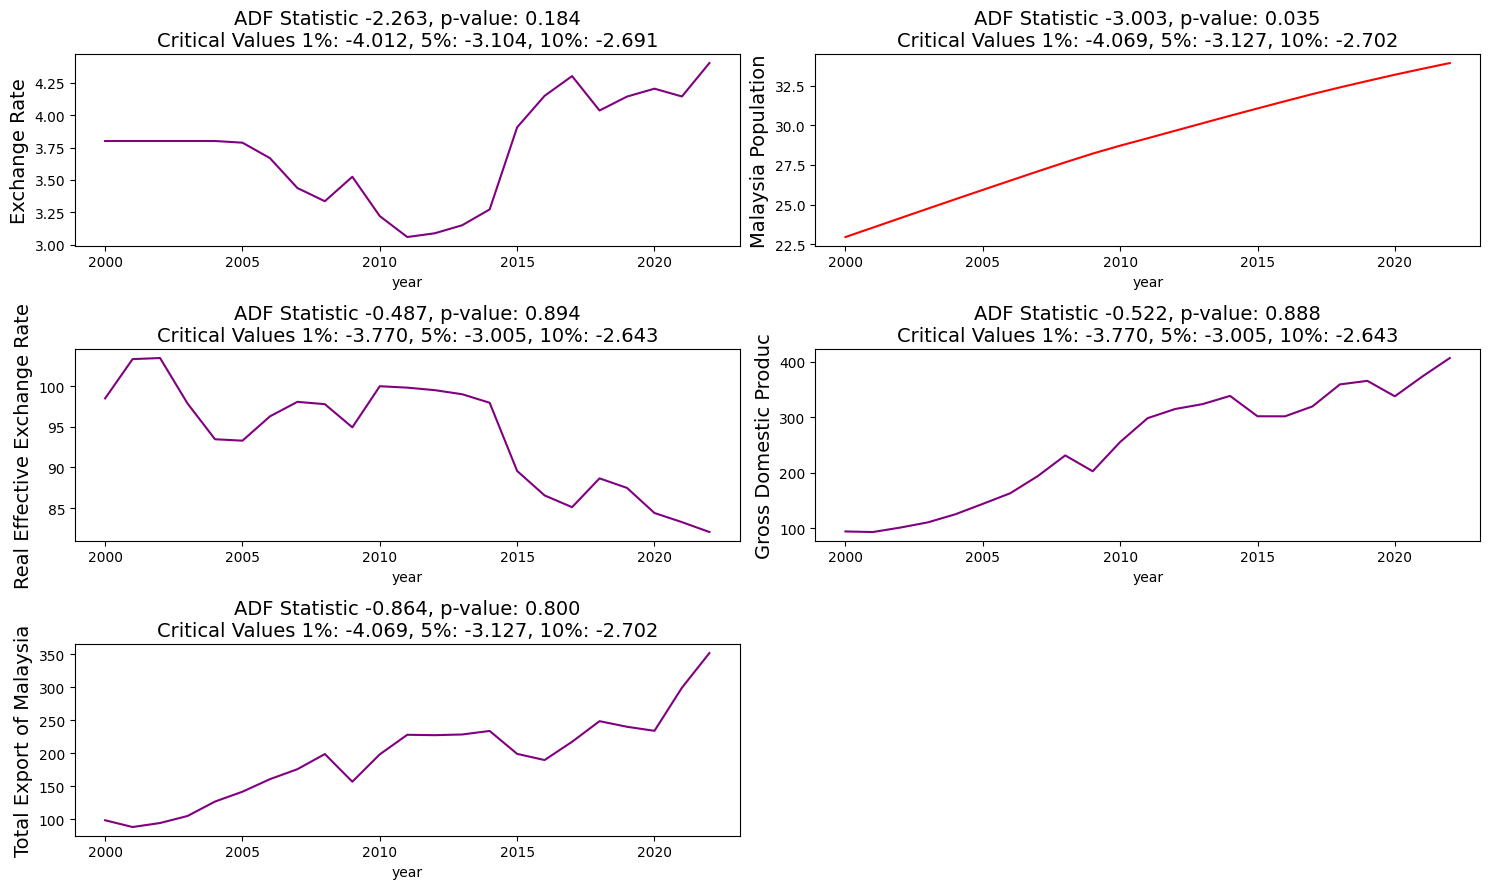

In [5]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=final_df['year'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(final_df['ER'].values, 'Exchange Rate', ax[0, 0])
visualize_adfuller_results(final_df['REER'].values, 'Real Effective Exchange Rate', ax[1, 0])
visualize_adfuller_results(final_df['Pop'].values, 'Malaysia Population', ax[0, 1])
visualize_adfuller_results(final_df['GDP'].values, 'Gross Domestic Produc', ax[1, 1])
visualize_adfuller_results(final_df['Export'].values, 'Total Export of Malaysia', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

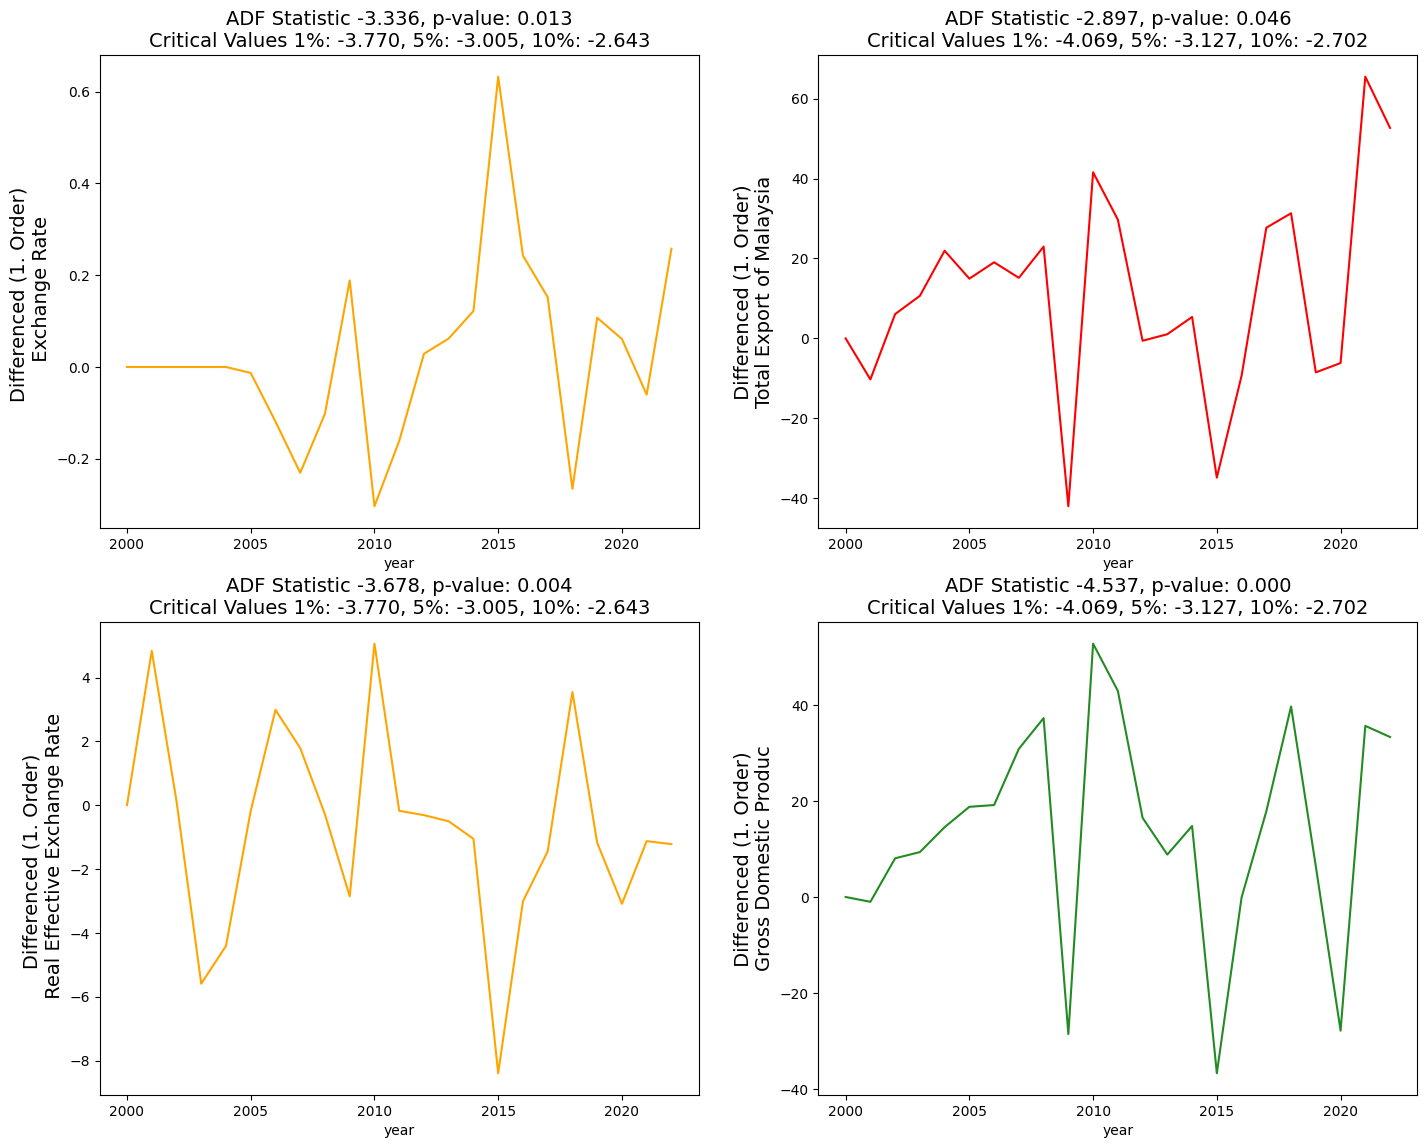

In [6]:
# First Order Differencing
ts_diff = np.diff(final_df['Export'])
final_df['Export1'] = np.append([0], ts_diff)

ts_diff = np.diff(final_df['ER'])
final_df['ER'] = np.append([0], ts_diff)

ts_diff = np.diff(final_df['REER'])
final_df['REER'] = np.append([0], ts_diff)

ts_diff = np.diff(final_df['GDP'])
final_df['GDP'] = np.append([0], ts_diff)

# Reconduct the ADF test to check for the stationarity of data
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(17, 13.5))
visualize_adfuller_results(final_df['ER'].values, 'Differenced (1. Order) \n Exchange Rate', ax[0, 0])
visualize_adfuller_results(final_df['REER'].values, 'Differenced (1. Order) \n Real Effective Exchange Rate', ax[1, 0])
visualize_adfuller_results(final_df['GDP'].values, ' Differenced (1. Order) \nGross Domestic Produc', ax[1, 1])
visualize_adfuller_results(final_df['Export1'].values, ' Differenced (1. Order) \nTotal Export of Malaysia', ax[0, 1])

# Modeling
## Data Splitting into Training and Testing Set

In [58]:
train_size = int(0.8 * len(final_df))
test_size = len(final_df) - train_size 

print(train_size, test_size)

univariate_df = final_df[['year', 'Export1']].copy()

train_data = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_test, y_test = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

18 5


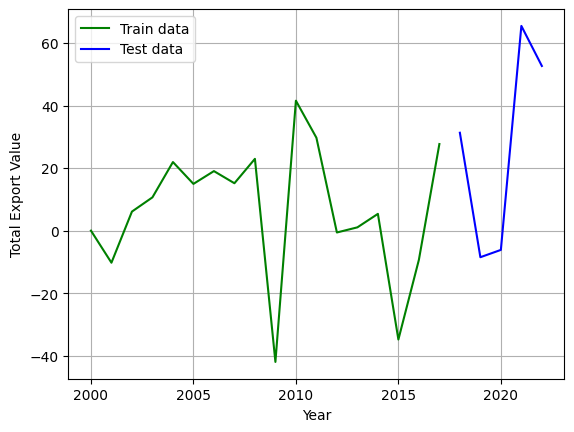

In [59]:
#plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Total Export Value')
plt.plot(x_train, y_train, 'green', label='Train data')
plt.plot(x_test, y_test, 'blue', label='Test data')
plt.legend()

## Autoregressive Integrated Moving Average (ARIMA) Model

### Identification of the best performance ARIMA model via auto-arima
Auto ARIM helps to automatically identify the optimal order for an ARIMA model.
The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, forecast::auto.arima.

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=176.706, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=171.600, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=174.755, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=167.862, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=165.467, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=163.470, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=165.918, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 0.662 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   N

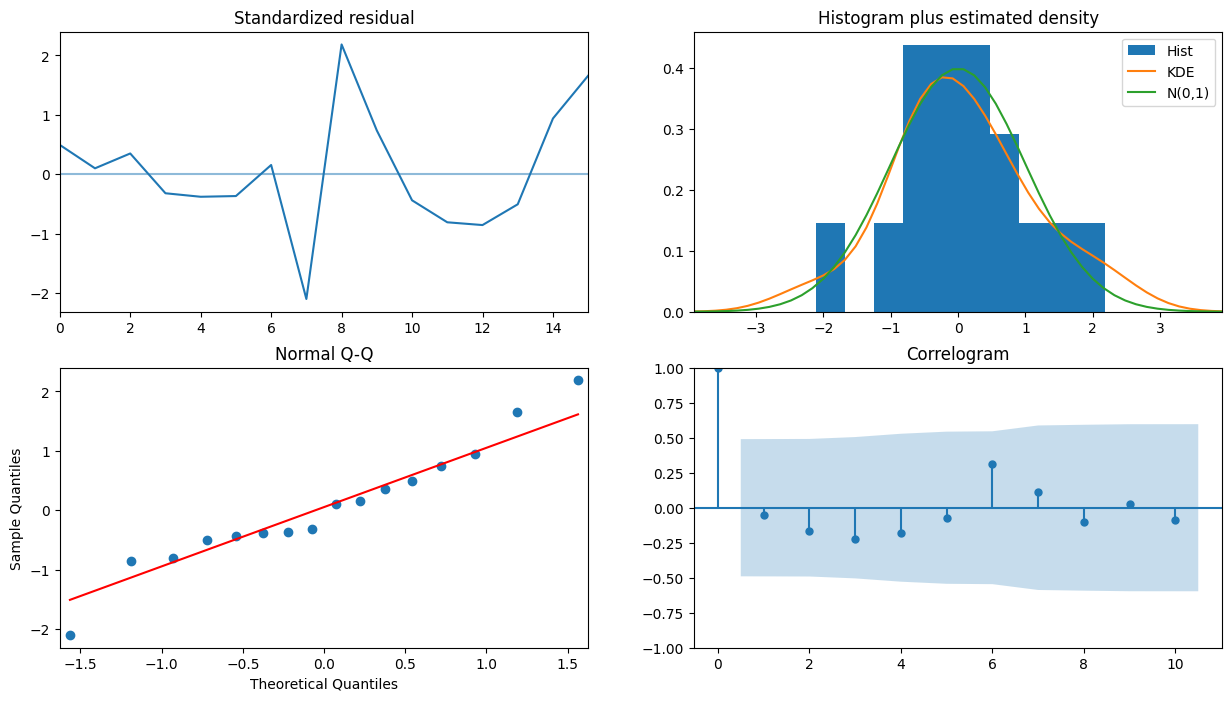

In [31]:
model_autoARIMA = auto_arima(y_train, start_p=0, start_q=0, 
                             test ='adf',       # use adftest to find optimal 'd'
                              max_p=3, max_q=3, # maximum p and q
                              m=1,              # frequency of series
                              d=None,           # let model determine 'd'
                              seasonal=False,   # No Seasonality
                              start_P=0, 
                              D=0, 
                              trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True)

print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

### Fit the data into the ARIMA (3, 2, 0) model

In [32]:
# Fit model
model = ARIMA(y_train, order=(3,2,0))

model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Export1   No. Observations:                   18
Model:                 ARIMA(3, 2, 0)   Log Likelihood                 -77.735
Date:                Tue, 15 Aug 2023   AIC                            163.470
Time:                        19:52:31   BIC                            166.560
Sample:                             0   HQIC                           163.628
                                 - 18                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2939      0.225     -5.739      0.000      -1.736      -0.852
ar.L2         -1.1173      0.386     -2.892      0.004      -1.874      -0.360
ar.L3         -0.5053      0.278     -1.817      0.0

In [60]:
# Forecast the results using the test data
fc = model_fit.forecast(5, alpha=0.05)  # 95% conf
print(fc)

18   -1.10
19    9.19
20   36.62
21   31.47
22   29.57
Name: predicted_mean, dtype: float64


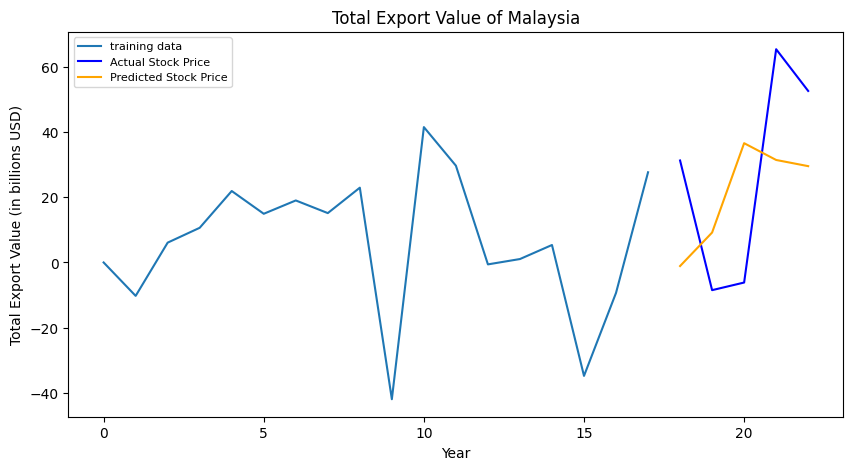

In [61]:
# Make as pandas series
fc_series = pd.Series(fc)

# PLot graph to view the predicted and actual total export value
plt.figure(figsize=(10,5), dpi=100)
plt.plot(y_train, label='training data')
plt.plot(y_test, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.title('Total Export Value of Malaysia')
plt.xlabel('Year')
plt.ylabel('Total Export Value (in billions USD)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Peformance Evaluation

In [67]:
mse = mean_squared_error(y_test, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_test, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_test, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_test.iloc[:,0] - fc)/np.abs(y_test.iloc[:,0]))
print('MAPE: '+str(mape))

MSE: 976.6692731634135
MAE: 29.995833184325914
RMSE: 31.25170832392069
MAPE: 2.203543794353682
